In [1]:
import json
import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta

# Background

This notebook takes a closer look at issues relating to missing HMS smoke plume shapefile data. The main question is, do we treat shapefiles that are empty or missing for a given date as days where no smoke plumes were observed, or as missing data?

To inform possible answers, the notebook asks the following questions:
1. What is the monthly spread of missing and empty shapefiles?
2. Which missing or empty dates coincide with large wildfires in the state of California?

This notebook reviews a json file of dates for which either an empty shapefile or no shapefile is available from https://satepsanone.nesdis.noaa.gov/pub/FIRE/web/HMS/Smoke_Polygons/Shapefile/. This json was created using the script 2_produce_date_json.py. To support its analysis, it also uses or references:
- EPA's [Climate Change Indicators: Wildfires](https://www.epa.gov/climate-indicators/climate-change-indicators-wildfires) report.
- CalFIRE's wildfire datasets for the [2000s](https://data.ca.gov/dataset/2000s) and [2010s](https://data.ca.gov/dataset/2010s). These datasets only contain wildfires covering over 5000 acres.

Datasets considered but not ultimately used include:
- MTBS [Fire Bundle data for the state of California](https://mtbs.gov/direct-download) - does not have containment dates for the fires listed.
- https://github.com/BuzzFeedNews/2018-07-wildfire-trends/tree/master/data/us_fires

## Load data

In [2]:
# read in missing days file
f = "../data/hms_2005_2021_absent_dates.json"
with open(f, "r") as file:
    absent = json.load(file)
    
absent

{'first_date': '2005-08-05',
 'last_date': '2021-12-31',
 'missing': ['2005-08-09', '2005-08-10', '2006-03-27', '2006-04-01',
  '2006-07-14', '2006-07-15', '2006-11-04', '2007-03-31',
  '2007-08-21', '2008-01-23', '2008-01-24', '2008-03-05',
  '2009-01-30', '2009-04-08', '2012-10-07', '2015-06-02',
  '2015-08-20', '2016-03-06', '2016-11-12', '2017-04-27',
  '2017-05-31', '2017-06-01', '2017-06-22', '2017-07-18',
  '2019-07-10', '2019-08-10', '2020-07-08'],
 'no_entries': ['2005-12-18', '2006-01-22', '2006-01-29',
  '2006-06-30', '2006-12-24', '2007-01-08', '2007-02-03',
  '2007-04-10', '2007-12-12', '2007-12-25', '2008-06-05',
  '2008-12-15', '2008-12-25', '2008-12-26', '2009-06-05',
  '2009-10-13', '2009-12-15', '2010-02-09', '2010-02-23',
  '2010-12-26', '2011-11-01', '2011-12-25', '2012-04-24',
  '2012-12-16', '2012-12-23', '2013-01-04', '2013-01-10',
  '2013-11-27', '2013-11-28', '2013-12-01', '2013-12-27',
  '2014-01-06', '2014-01-07', '2014-02-02', '2014-12-21',
  '2014-12-22', '

## Question 1: What is the monthly spread of missing and empty shapefiles?

This section visualizes the number of missing and empty shapefiles per month.
The first two graphs break down counts by year. The combined graph uses stacked bars to visually compare missing versus empty shapefiles for each month.

One would expect more smoke-free observations in winter months, in rough alignment with Figure 6 on the EPA's [Climate Change Indicators: Wildfires](https://www.epa.gov/climate-indicators/climate-change-indicators-wildfires).

A simple chart of dates by month as represented in each set:

[]

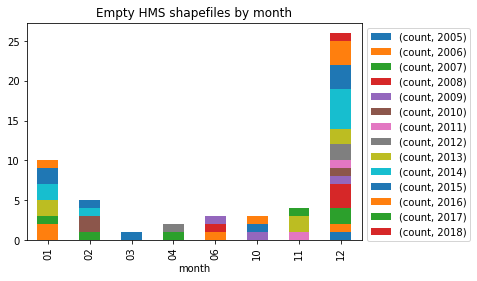

In [3]:
empty = pd.DataFrame({"count":[1]*len(absent['no_entries']), "date":pd.to_datetime(absent['no_entries'])})
empty['month'] = empty['date'].apply(lambda x: x.strftime('%m'))
empty['year'] = empty['date'].apply(lambda x: x.strftime('%Y'))
empty = empty.sort_values(by="month")
ax = empty[['month','year','count']].groupby(["month", "year"]).count().unstack('year').plot.bar(stacked=True)
ax.set_title("Empty HMS shapefiles by month",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

[]

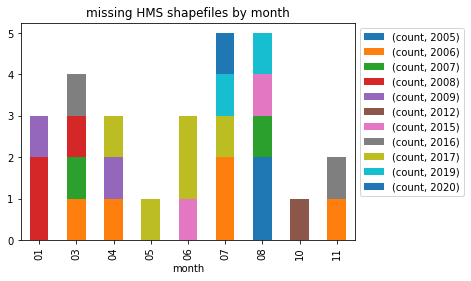

In [4]:
missing = pd.DataFrame({"count":[1]*len(absent['missing']), "date":pd.to_datetime(absent['missing'])})
missing['month'] = missing['date'].apply(lambda x: x.strftime('%m'))
missing['year'] = missing['date'].apply(lambda x: x.strftime('%Y'))
missing = missing.sort_values(by="month")
ax = missing[['month','year','count']].groupby(["month", "year"]).count().unstack('year').plot.bar(stacked=True)
ax.set_title("missing HMS shapefiles by month",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

[]

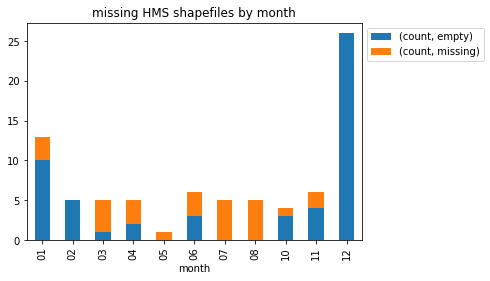

In [5]:
empty['source'] = "empty"
missing['source'] = "missing"
empty_missing = pd.concat([empty, missing], ignore_index=True)

em_ax = empty_missing[['month','source','count']].groupby(["month", "source"]).count().unstack('source').plot.bar(stacked=True)
em_ax.set_title("missing HMS shapefiles by month",color='black')
em_ax.legend(bbox_to_anchor=(1.0, 1.0))
em_ax.plot()

## Question 2: Which missing or empty dates coincide with large wildfires in the state of California?

To get a clearer understanding of what missing versus empty shapefiles represent, we verify the dates of missing and empty shapefile dates against the burn dates of California wildfires 2005-2019.

The dataset used to reference CA burn dates is CalFIRE's wildfire datasets for the [2000s](https://data.ca.gov/dataset/2000s) and [2010s](https://data.ca.gov/dataset/2010s). These datasets only contain wildfires covering over 5000 acres.

It would be better to use for comparison a dataset of daily acreage burned, but that does not appear to be available at this time.

Findings:
- 12 missing dates and 19 dates with empty shapefiles occur between the start and end dates of California wildfires that burned over 5000 acres.
- 7 missing dates and 2 dates with empty shapefiles occur between the start and end dates of California wildfires that burned over 50000 acres.


In [6]:
# produce combined df of 2000s and 2010s wildfire data
dfs = []
for n in [0,1]:
    f = f"../data/CalFIRE_perimeters/California_Fire_Perimeters-20{n}0s.csv"
    tmp_df = pd.read_csv(f)
    dfs.append(tmp_df)
fire_df_ca = pd.concat(dfs, ignore_index=True)
fire_df_ca = fire_df_ca.loc[fire_df_ca['YEAR_'] > 2004].sort_values("YEAR_")
fire_df_ca

,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,REPORT_AC,GIS_ACRES,OBJECTIVE,SHAPEAREA,SHAPELEN
189,40383,2005,CA,NPS,MNP,WILDHORSE,6392,2005/06/22 00:00:00+00,2005/07/07 00:00:00+00,63436.00,63771.406250,1.0,3.865648e+08,183958.092196
182,39888,2005,CA,NPS,KNP,COMB,00000015,2005/07/22 00:00:00+00,2005/12/01 00:00:00+00,9753.94,9756.466797,2.0,6.173096e+07,68042.112221
25,23065,2005,CA,USF,BDF,BLAISDELL,00000000,2005/08/31 00:00:00+00,2005/08/31 00:00:00+00,5493.00,5491.787598,1.0,3.231802e+07,30958.749405
24,23010,2005,CA,CDF,SCU,TESLA,00002920,2005/07/19 00:00:00+00,2005/07/20 00:00:00+00,6440.00,6440.355957,1.0,4.165893e+07,50941.358961
23,22386,2005,CA,CDF,RRU,WOODHOUSE,00083672,2005/10/05 00:00:00+00,2005/10/07 00:00:00+00,6500.00,6532.973145,1.0,3.852468e+07,32174.275434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,42566,2019,CA,CDF,TGU,RED BANK,9386.0,2019/09/05 00:00:00+00,2019/09/15 00:00:00+00,8822.00,8822.024414,1.0,6.119165e+07,59558.640807
361,42478,2019,CA,CDF,LNU,KINCADE,19376.0,2019/10/23 00:00:00+00,2019/11/10 00:00:00+00,NaN,77762.140625,1.0,5.171126e+08,238568.856409
369,42745,2019,CA,USF,PNF,WALKER,1324.0,2019/09/04 00:00:00+00,2020/01/15 00:00:00+00,54628.00,54614.902344,1.0,3.780274e+08,271202.794103
364,42689,2019,CA,USF,INF,TABOOSE,2018.0,2019/09/04 00:00:00+00,2019/11/23 00:00:00+00,10265.00,10267.631836,1.0,6.530472e+07,96472.369703


In [7]:
fire_df_ca = fire_df_ca.loc[(fire_df_ca['ALARM_DATE'].notna()) & (fire_df_ca['CONT_DATE'].notna())].copy()
fire_df_ca['ALARM_DATE'] = pd.to_datetime(fire_df_ca['ALARM_DATE'].astype(str).str[:11])
fire_df_ca['CONT_DATE'] = pd.to_datetime(fire_df_ca['CONT_DATE'].astype(str).str[:11])
fire_df_ca

,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,REPORT_AC,GIS_ACRES,OBJECTIVE,SHAPEAREA,SHAPELEN
189,40383,2005,CA,NPS,MNP,WILDHORSE,6392,2005-06-22,2005-07-07,63436.00,63771.406250,1.0,3.865648e+08,183958.092196
182,39888,2005,CA,NPS,KNP,COMB,00000015,2005-07-22,2005-12-01,9753.94,9756.466797,2.0,6.173096e+07,68042.112221
25,23065,2005,CA,USF,BDF,BLAISDELL,00000000,2005-08-31,2005-08-31,5493.00,5491.787598,1.0,3.231802e+07,30958.749405
24,23010,2005,CA,CDF,SCU,TESLA,00002920,2005-07-19,2005-07-20,6440.00,6440.355957,1.0,4.165893e+07,50941.358961
23,22386,2005,CA,CDF,RRU,WOODHOUSE,00083672,2005-10-05,2005-10-07,6500.00,6532.973145,1.0,3.852468e+07,32174.275434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,42566,2019,CA,CDF,TGU,RED BANK,9386.0,2019-09-05,2019-09-15,8822.00,8822.024414,1.0,6.119165e+07,59558.640807
361,42478,2019,CA,CDF,LNU,KINCADE,19376.0,2019-10-23,2019-11-10,NaN,77762.140625,1.0,5.171126e+08,238568.856409
369,42745,2019,CA,USF,PNF,WALKER,1324.0,2019-09-04,2020-01-15,54628.00,54614.902344,1.0,3.780274e+08,271202.794103
364,42689,2019,CA,USF,INF,TABOOSE,2018.0,2019-09-04,2019-11-23,10265.00,10267.631836,1.0,6.530472e+07,96472.369703


In [8]:
wildfire_pairs_ca = list(fire_df_ca[["ALARM_DATE","CONT_DATE"]].itertuples(index=False, name=None))
wildfire_pairs_ca

[(Timestamp('2005-06-22 00:00:00'), Timestamp('2005-07-07 00:00:00')),
 (Timestamp('2005-07-22 00:00:00'), Timestamp('2005-12-01 00:00:00')),
 (Timestamp('2005-08-31 00:00:00'), Timestamp('2005-08-31 00:00:00')),
 (Timestamp('2005-07-19 00:00:00'), Timestamp('2005-07-20 00:00:00')),
 (Timestamp('2005-10-05 00:00:00'), Timestamp('2005-10-07 00:00:00')),
 (Timestamp('2005-08-22 00:00:00'), Timestamp('2005-09-09 00:00:00')),
 (Timestamp('2005-07-18 00:00:00'), Timestamp('2005-07-24 00:00:00')),
 (Timestamp('2005-09-28 00:00:00'), Timestamp('2005-10-10 00:00:00')),
 (Timestamp('2005-06-22 00:00:00'), Timestamp('2005-07-07 00:00:00')),
 (Timestamp('2006-07-24 00:00:00'), Timestamp('2006-08-04 00:00:00')),
 (Timestamp('2006-07-22 00:00:00'), Timestamp('2006-07-22 00:00:00')),
 (Timestamp('2006-07-22 00:00:00'), Timestamp('2006-07-27 00:00:00')),
 (Timestamp('2006-07-21 00:00:00'), Timestamp('2006-11-11 00:00:00')),
 (Timestamp('2006-06-19 00:00:00'), Timestamp('2006-07-20 00:00:00')),
 (Time

In [9]:
missing_dates = []
for d in absent['missing']:
    for i in wildfire_pairs_ca:
        if i[0] < datetime.strptime(d, '%Y-%m-%d') < i[1]:
            missing_dates.append(d)
            continue
        continue
print(set(missing_dates))
print(len(set(missing_dates)))

{'2016-11-12', '2015-08-20', '2019-08-10', '2006-11-04', '2006-07-14', '2005-08-09', '2007-08-21', '2007-03-31', '2012-10-07', '2017-07-18', '2006-07-15', '2005-08-10'}
12


In [10]:
empty_dates = []
for d in absent['no_entries']:
    for i in wildfire_pairs_ca:
        if i[0] < datetime.strptime(d, '%Y-%m-%d') < i[1]:
            empty_dates.append(d)
            continue
        continue
print(set(empty_dates))
print(len(set(empty_dates)))

{'2007-02-03', '2017-11-12', '2009-10-13', '2015-12-25', '2015-10-28', '2016-10-21', '2006-06-30', '2013-12-01', '2007-12-25', '2013-11-28', '2008-12-15', '2015-12-24', '2007-01-08', '2006-12-24', '2007-04-10', '2011-11-01', '2007-12-12', '2013-11-27', '2008-06-05'}
19


#### What if we try with more acreage?

The columns below check how many dates from each category coincide with wildfires of >50000 acres.

In [11]:
fire_df_ca_10x = fire_df_ca.loc[fire_df_ca['GIS_ACRES'] > 50000]
fire_df_ca_10x

,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,REPORT_AC,GIS_ACRES,OBJECTIVE,SHAPEAREA,SHAPELEN
189,40383,2005,CA,NPS,MNP,WILDHORSE,6392,2005-06-22,2005-07-07,63436.0,63771.406250,1.0,3.865648e+08,183958.092196
84,36032,2006,CA,CDF,BDU,SAWTOOTH COMPLEX,00007229,2006-07-09,2006-07-18,61700.0,61767.175781,1.0,3.657656e+08,172485.640683
115,37380,2006,CA,USF,SHF,BAKE-OVEN,00001693,2006-07-23,2006-11-30,66113.0,65050.050781,1.0,4.627917e+08,163417.999970
119,37437,2006,CA,USF,LPF,DAY,00002023,2006-09-04,2006-10-30,162702.0,161815.656250,1.0,9.691488e+08,281247.961414
0,21947,2007,CA,USF,ANF,RANCH,00000166,2007-10-20,2007-11-15,54716.0,58410.335938,1.0,3.488685e+08,205467.427787
8,22057,2007,CA,USF,PNF,MOONLIGHT,00000098,2007-09-03,2007-09-25,64995.0,64959.957031,1.0,4.513896e+08,107611.061063
20,22261,2007,CA,CDF,MVU,HARRIS 2,00010427,2007-10-21,2007-11-02,NaN,90728.328125,1.0,5.193174e+08,239030.758622
16,22221,2007,CA,CDF,SBC,ZACA,00000020,2007-07-04,2007-09-02,240207.0,240358.703125,1.0,1.442300e+09,339556.732178
15,22220,2007,CA,CDF,MVU,WITCH,00000082,2007-10-21,2007-10-31,197990.0,162070.468750,1.0,9.365499e+08,415872.080441
158,38304,2008,CA,USF,SRF,MILL,NaN,2008-06-20,2008-10-03,65834.0,65882.039062,1.0,4.763191e+08,179116.424240


In [12]:
wildfire_pairs_ca_10x = list(fire_df_ca_10x[["ALARM_DATE","CONT_DATE"]].itertuples(index=False, name=None))
wildfire_pairs_ca_10x

[(Timestamp('2005-06-22 00:00:00'), Timestamp('2005-07-07 00:00:00')),
 (Timestamp('2006-07-09 00:00:00'), Timestamp('2006-07-18 00:00:00')),
 (Timestamp('2006-07-23 00:00:00'), Timestamp('2006-11-30 00:00:00')),
 (Timestamp('2006-09-04 00:00:00'), Timestamp('2006-10-30 00:00:00')),
 (Timestamp('2007-10-20 00:00:00'), Timestamp('2007-11-15 00:00:00')),
 (Timestamp('2007-09-03 00:00:00'), Timestamp('2007-09-25 00:00:00')),
 (Timestamp('2007-10-21 00:00:00'), Timestamp('2007-11-02 00:00:00')),
 (Timestamp('2007-07-04 00:00:00'), Timestamp('2007-09-02 00:00:00')),
 (Timestamp('2007-10-21 00:00:00'), Timestamp('2007-10-31 00:00:00')),
 (Timestamp('2008-06-20 00:00:00'), Timestamp('2008-10-03 00:00:00')),
 (Timestamp('2008-06-21 00:00:00'), Timestamp('2008-07-27 00:00:00')),
 (Timestamp('2008-07-02 00:00:00'), Timestamp('2008-07-24 00:00:00')),
 (Timestamp('2008-06-08 00:00:00'), Timestamp('2008-07-10 00:00:00')),
 (Timestamp('2009-08-08 00:00:00'), Timestamp('2009-08-22 00:00:00')),
 (Time

In [13]:
missing_dates_10x = []
for d in absent['missing']:
    for i in wildfire_pairs_ca_10x:
        if i[0] < datetime.strptime(d, '%Y-%m-%d') < i[1]:
            missing_dates_10x.append(d)
            continue
        continue
print(set(missing_dates_10x))
print(len(set(missing_dates_10x)))

{'2015-08-20', '2006-11-04', '2006-07-14', '2007-08-21', '2012-10-07', '2017-07-18', '2006-07-15'}
7


In [14]:
empty_dates_10x = []
for d in absent['no_entries']:
    for i in wildfire_pairs_ca_10x:
        if i[0] < datetime.strptime(d, '%Y-%m-%d') < i[1]:
            empty_dates_10x.append(d)
            continue
        continue
print(set(empty_dates_10x))
print(len(set(empty_dates_10x)))

{'2017-11-12', '2015-10-28'}
2
